In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import json

from scipy.fft import rfft, rfftfreq, irfft
# from statsmodels.tsa import stattools
from scipy.signal import stft, istft

import pandas.util.testing as tm
from scipy.signal import find_peaks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
from tqdm import tqdm

In [4]:
persons = ['Airat', 'Nazir', 'Arkasha']
sectors = ['FREEG', 'FLEEG', 'BREEG', 'BLEEG', 'ECG']

In [11]:
with open('/content/drive/MyDrive/Study/Mag/1st/Neurophysiology/Lab3/resources.json', 'r') as f:
  res = json.load(f)

In [ ]:
for i in persons:
  temp = list()
  for j, k in zip(res[i]['BioRadio Event'], range(len(res[i]['BioRadio Event']))):
    if j:
      temp.append(k/1000)
  res[i]['BioRadio Event'] = temp

In [ ]:
res['Airat']['BioRadio Event']

[11.432,
 132.792,
 142.104,
 264.296,
 295.576,
 307.496,
 317.408,
 341.168,
 374.432,
 381.44,
 399.44,
 416.512,
 455.968,
 473.152,
 486.848,
 497.376,
 509.376,
 519.304,
 526.408,
 541.048,
 566.408,
 579.232,
 620.672,
 644.312,
 652.328,
 664.0,
 677.32,
 691.024,
 700.168,
 708.992,
 724.256,
 739.008,
 747.024]

In [7]:
# @title Data visualization
def visualize(person, start='0:20', end='0:50', rate=1000):
  m, s = map(int, start.split(':'))
  start = (m * 60 + s) * rate
  m, s = map(int, end.split(':'))
  end = (m * 60 + s) * rate
  data = res[person]
  sectors = ['FREEG', 'FLEEG', 'BREEG', 'BLEEG']
  events = list()
  n = len(data['ECG'])
  if not end+1:
    end = n-1
    
  with plt.rc_context({'xtick.color':'#d4d4d4', 'ytick.color':'#d4d4d4',
                       'font.size':'16', 'axes.titlecolor':'#d4d4d4',
                       'axes.labelcolor':'#d4d4d4'}):
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(person, color='#d4d4d4')
    fig.patch.set_facecolor('#383838')

    for i, sector in zip(range(1, 5), sectors):
      ax = fig.add_subplot(3, 2, i)
      ax.set_title(sector)
      ax.plot(data[sector][start:end])
      ax.minorticks_on()
      for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
      ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
          lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                                  int((start+x)/rate%60))))
  
    
    ax = fig.add_subplot(3, 1, 3)
    ax.set_title('ECG')
    ax.plot(data['ECG'][start:end])
    ax.minorticks_on()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
      label.set_fontsize(12)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                                  int((start+x)/rate%60))))


In [8]:
# @title Identifying rhythms
def rythms(person, start='00:05', end='01:00', sector='FREEG', rate=1000, *, 
           debug = False, g=True):
  m, s = map(int, start.split(':'))
  start = (m * 60 + s) * rate
  m, s = map(int, end.split(':'))
  end = (m * 60 + s) * rate

  y = res[person][sector][start:end]

  n = len(y)
  duration = n / rate

  yf = rfft(y)
  xf = rfftfreq(n, 1/rate)

  for i in range(len(xf)):
    if not 1 <= xf[i] <= 60:
      yf[i] = 0

  if debug:
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, 60)
    ax.plot(xf, np.abs(yf))
    plt.show()

  f, t, yf = stft(irfft(yf), nperseg=rate)  
  f *= rate

  alpha = np.copy(yf)
  beta = np.copy(yf)
  delta = np.copy(yf)
  gamma = np.copy(yf)
  tetta = np.copy(yf)


  for i in range(len(f)):
    if f[i]<1 or f[i]>50:
      yf[i]=0
    if f[i]<8 or f[i]>13:
      alpha[i]=0
    if f[i]<14 or f[i]>30:
      beta[i]=0
    if f[i]<30 or f[i]>50:
      gamma[i]=0
    if f[i]<4 or f[i]>8:
      tetta[i]=0
    if f[i]<1 or f[i]>4:
      delta[i]=0

  _, filtered_yf = istft(Zxx=yf, nperseg=rate)
  _, alpha_sig = istft(Zxx=alpha, nperseg=rate)
  _, beta_sig = istft(Zxx=beta, nperseg=rate)
  _, gamma_sig = istft(Zxx=gamma, nperseg=rate)
  _, tetta_sig = istft(Zxx=tetta, nperseg=rate)
  _, delta_sig = istft(Zxx=delta, nperseg=rate)

  X =  np.arange(0.0, duration, 1/rate)

  x = X

  with plt.rc_context({'xtick.color':'#d4d4d4', 'ytick.color':'#d4d4d4',
                       'font.size':'16', 'axes.titlecolor':'#d4d4d4',
                       'axes.labelcolor':'#d4d4d4'}):
    fig= plt.figure(figsize=(20,10))

    fig.suptitle(f'Person: {person}; Sector: {sector}',
                 color='#d4d4d4')
    fig.patch.set_facecolor('#383838')

    ax = fig.add_subplot(2, 1, 1)

    ax.set_xlabel('Time')
    ax.patch.set_alpha(1.0)
    
    ax.plot(filtered_yf, label='cleaned')
    ax.plot(y, label='noise', alpha=0.5)

    ax.set_yticklabels([])
    ax.set_title('Signal')
    ax.legend(frameon=False, loc='best', ncol=2, prop={'size': 12})

    ax.minorticks_on()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
      label.set_fontsize(12)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                                int((start+x)/rate%60))))
    
    if g:

      ax = fig.add_subplot(2, 2, 4)

      ax.set_xlabel('Time', color='#d4d4d4')

      ax.plot(gamma_sig[start:end], label='γ-rhythm', color='g')
      ax.plot(tetta_sig[start:end], label='θ-rhythm', color='r', alpha=0.5)
      ax.plot(delta_sig[start:end], label='δ-rhythm', color='b', alpha=0.25)

      ax.set_yticklabels([])
      ax.set_title('γ, θ, δ', fontsize=16, color='#d4d4d4')
      ax.legend(frameon=False, loc='best', ncol=2, prop={'size': 15})

      ax.minorticks_on()
      for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
      ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
          lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                                int((start+x)/rate%60))))
      
      ax = fig.add_subplot(2, 2, 3)
    else:
      ax = fig.add_subplot(2, 1, 2)

    ax.set_xlabel('Time', color='#d4d4d4')

    ax.plot(alpha_sig, label='α-rhythm', color='g')
    ax.plot(beta_sig, label='β-rhythm', color='r', alpha=0.5)

    ax.set_yticklabels([])
    ax.set_title('α, β', fontsize=16, color='#d4d4d4')
    ax.legend(frameon=False, loc='best', ncol=2, prop={'size': 15})

    ax.minorticks_on()
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
      label.set_fontsize(12)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                                int((start+x)/rate%60))))
    
      

    plt.show()

  # return filtered_yf, alpha_sig, beta_sig

In [30]:
# @title Calculating BPM
def BPM_vis(person, start='0:0', end='0:0', rate=1000, *,
            debug = False, h=0):

  m, s = map(int, start.split(':'))
  start = (m * 60 + s) * rate
  m, s = map(int, end.split(':'))
  end = (m * 60 + s) * rate

  if not end:
    end = len(res[person]['ECG'][:-20000])

  ecg = np.array(res[person]['ECG'][start:end])

  if not h:
    if person == 'Nazir':
      ecg *= -1
      h = 2
    else:
      h = 10
  
  yf = rfft(ecg)
  xf = rfftfreq(len(ecg), 1/rate)

  for i in range(len(xf)):
    if not 1 <= xf[i] <= 30:
      yf[i] = 0

  filtered = irfft(yf)

  data_size=len(ecg)
  d = rate/2
  R_peaks, _ = find_peaks(filtered, height=h, distance=d)
  print("Number of R-peaks:", len(R_peaks))

  if debug:
    fig = plt.figure(figsize=(20,3))
    ax = fig.add_subplot()
    ax.plot(R_peaks, ecg[R_peaks], 'or')
    ax.plot(ecg)
    ax.hlines(h, 0, len(ecg), 'g')
    plt.plot()

  bpm = list()
  for i, j in zip(R_peaks[:-1], R_peaks[1:]):
    bpm.append(60/((j-i)/1000))

  # fig = plt.figure(figsize=(20,5))
  # ax = fig.add_subplot()
  # ax.hist(bpm, bins=15)
  # ax.set_ylim(0, 30)
  # ax.set_xlim(60, 120)
  # plt.show()

  print(f'Averedge BPM: {sum(bpm)/len(bpm)}')

  def aprox(y, d=20):
    y1 = list()
    for i in tqdm(range(len(y[d:]))):
      y1.append(sum(y[i:d+i])/d)
    y1 = [y1[0]]*(d//2) + y1 + [y1[-1]]*(d//2)
    return y1

  with plt.rc_context({'xtick.color':'#d4d4d4', 'ytick.color':'#d4d4d4',
                       'font.size':'16', 'axes.titlecolor':'#d4d4d4',
                       'axes.labelcolor':'#d4d4d4'}):

    fig, ax = plt.subplots(1, 2, figsize=(20, 3))

    fig.patch.set_facecolor('#383838')

    ax[0].hist(bpm, bins=10)
    ax[0].set_ylim(0, 30)
    ax[0].set_xlim(50, 110)

    ax[1].set_title(f'Beats per minute')

    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('BPM')
    ax[1].minorticks_on()
    ax[1].grid(which='major',
            color = 'k', 
            linewidth = 2)
    ax[1].grid(which='minor', 
            color = 'k', 
            linestyle = ':')
    ax[1].plot(R_peaks[1:], aprox(bpm))
    for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
      label.set_fontsize(12)
    ax[1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, pos: '{0:02d}:{1:02d}'.format(int((start+x)/rate//60),
                                              int((start+x)/rate%60))))
    plt.show()


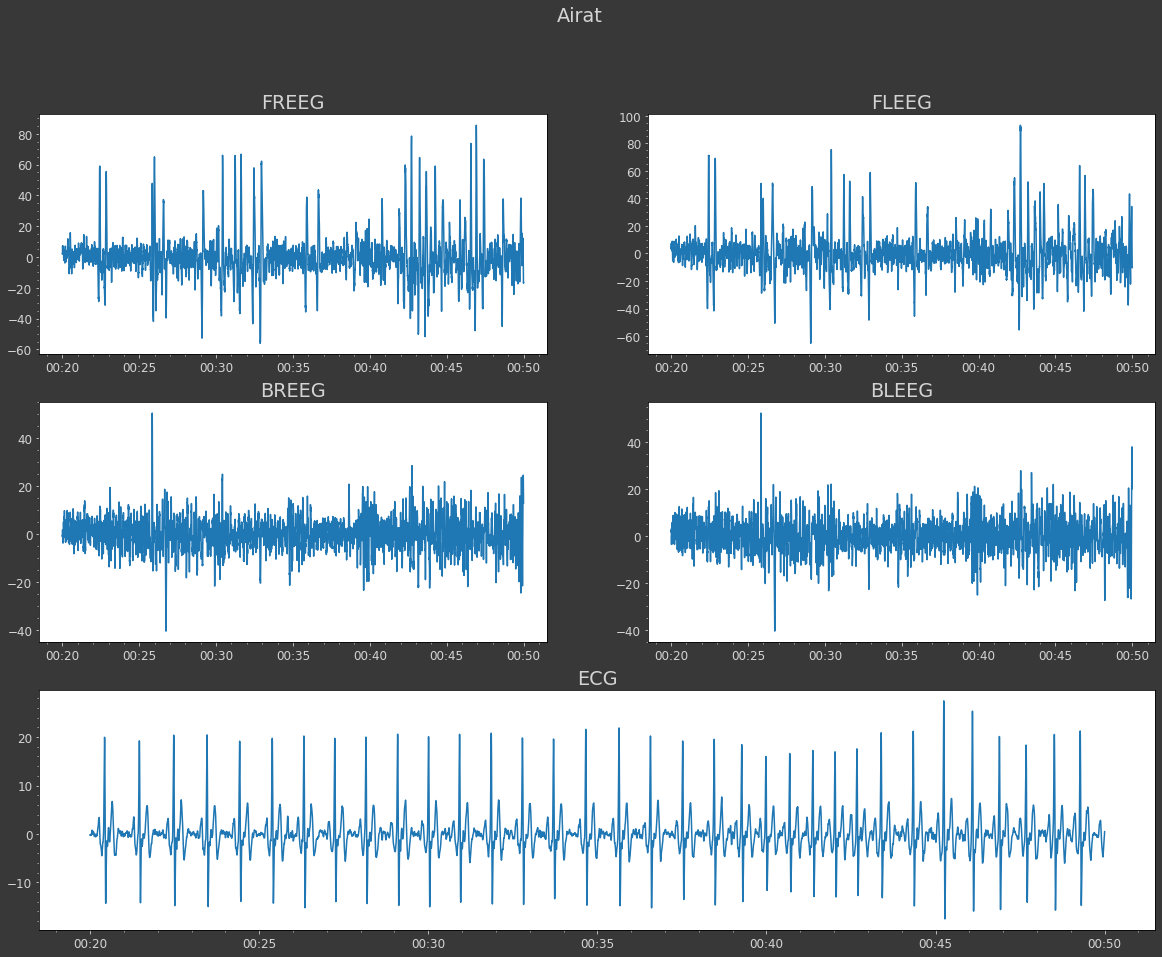

In [17]:
visualize('Airat')

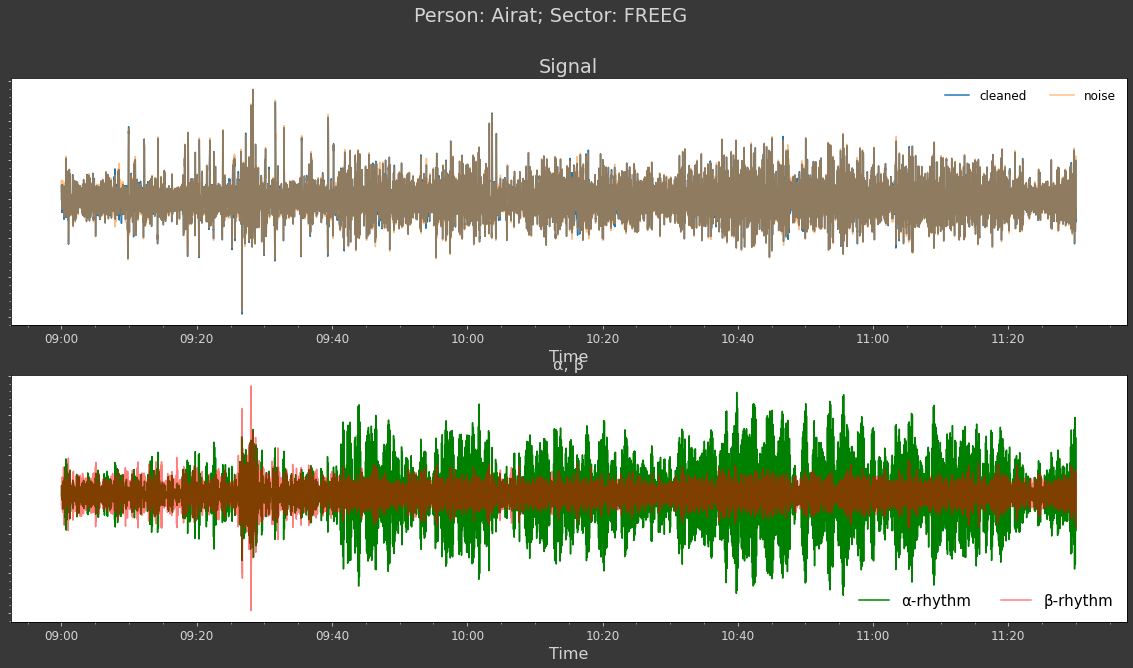

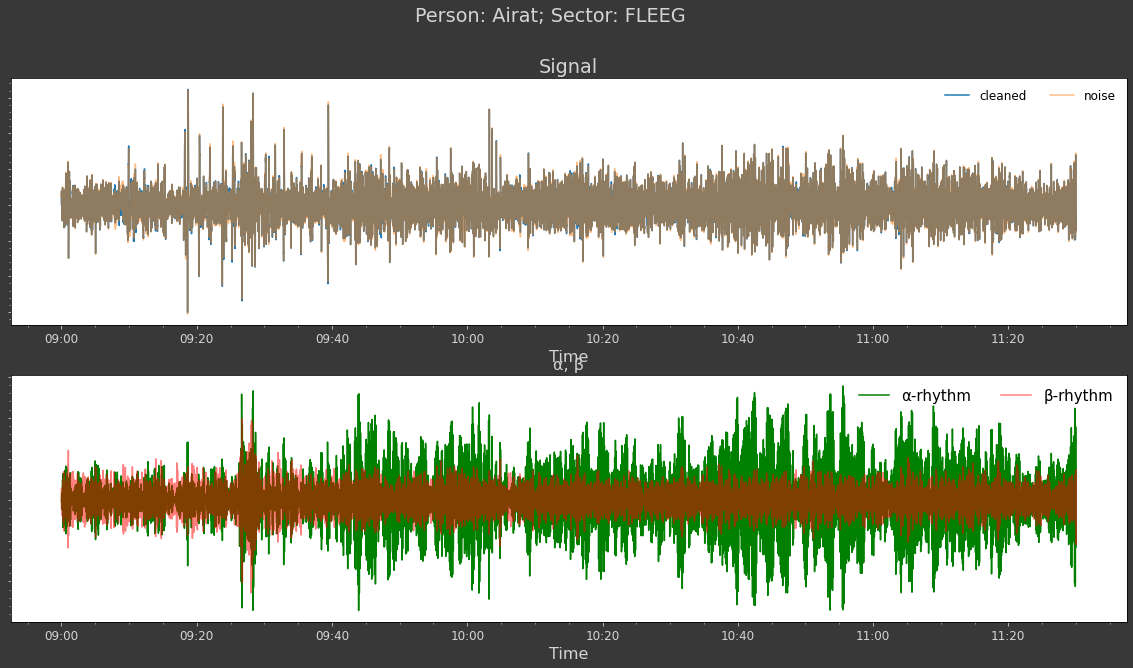

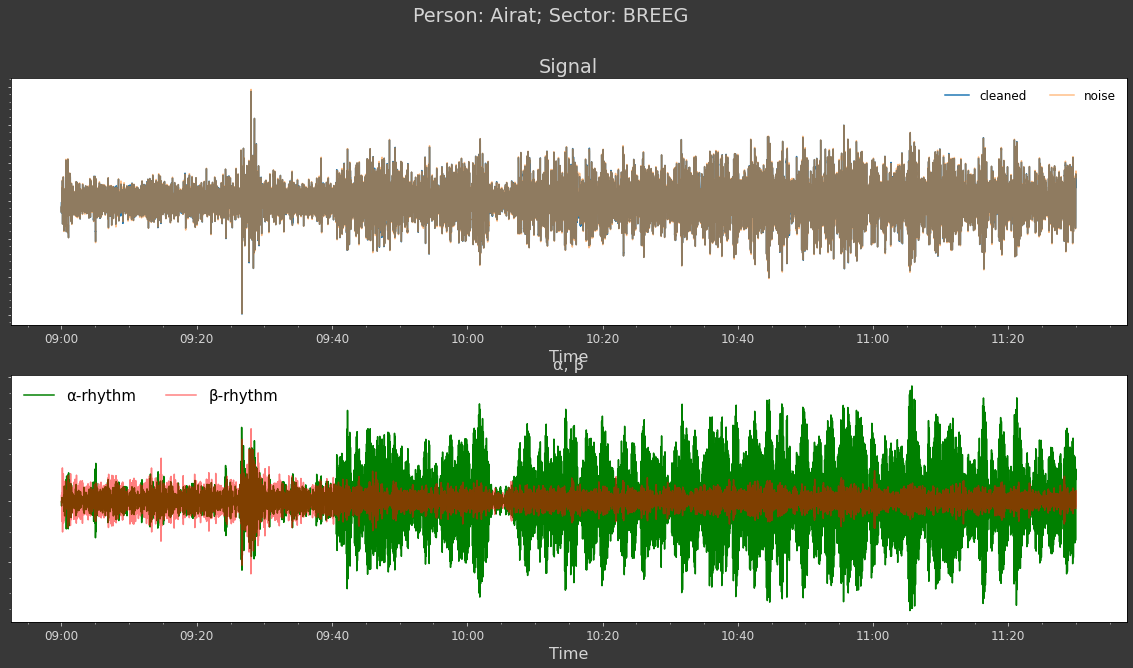

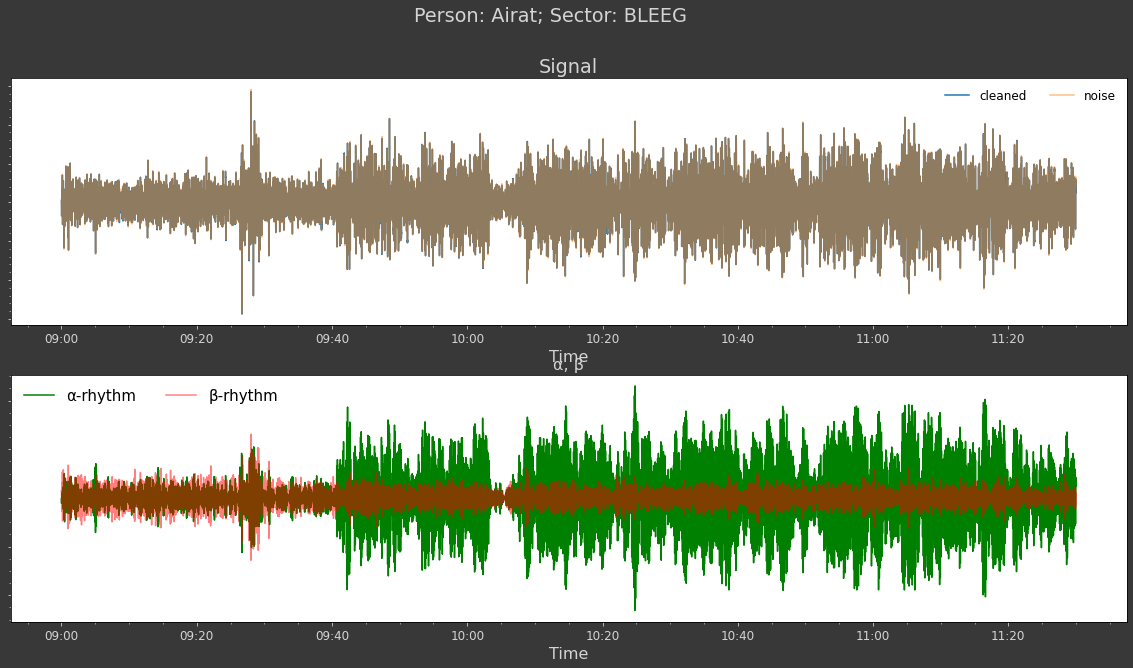

In [26]:
for i in sectors[:-1]:
  rythms('Airat', '9:00', '11:30', i, g=False)

In [ ]:
res['Airat']['BioRadio Event']

[11.432,
 132.792,
 142.104,
 264.296,
 295.576,
 307.496,
 317.408,
 341.168,
 374.432,
 381.44,
 399.44,
 416.512,
 455.968,
 473.152,
 486.848,
 497.376,
 509.376,
 519.304,
 526.408,
 541.048,
 566.408,
 579.232,
 620.672,
 644.312,
 652.328,
 664.0,
 677.32,
 691.024,
 700.168,
 708.992,
 724.256,
 739.008,
 747.024]

Number of R-peaks: 32
Averedge BPM: 64.20156553908886


100%|██████████| 11/11 [00:00<00:00, 12071.52it/s]


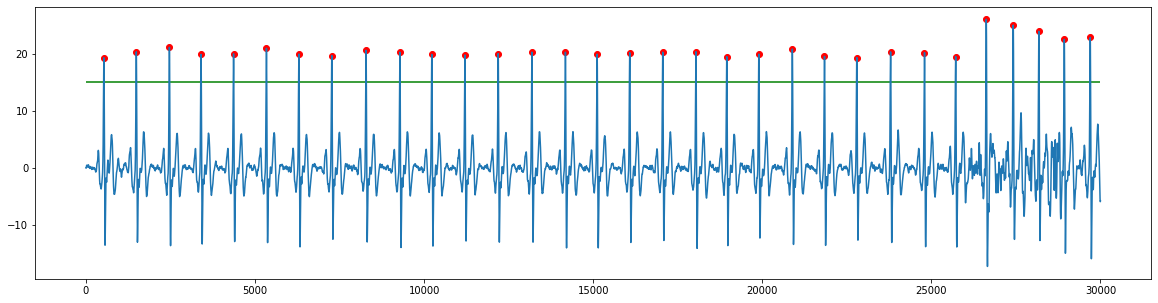

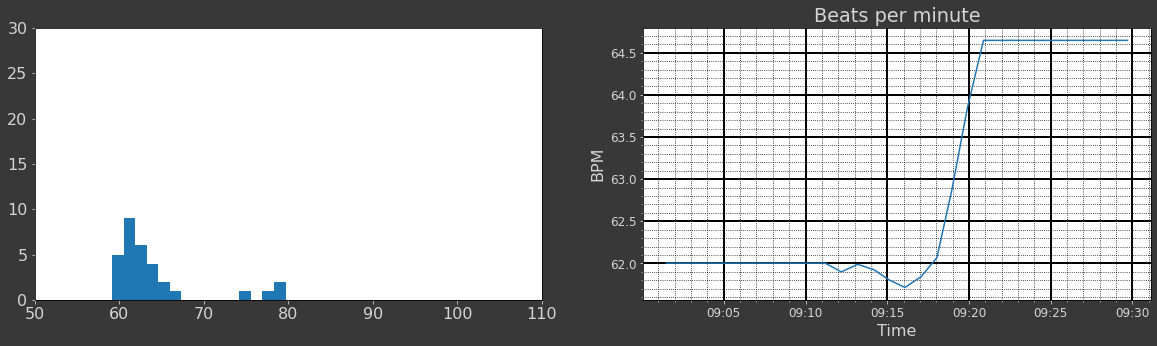

In [20]:
BPM_vis(p, f'9:0', f'9:30', h=15, debug=True)

Number of R-peaks: 110
Averedge BPM: 65.77829076096508


100%|██████████| 89/89 [00:00<00:00, 141291.85it/s]


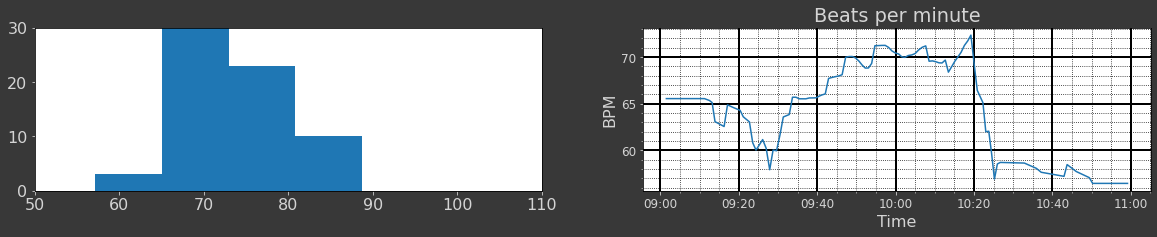

Number of R-peaks: 115
Averedge BPM: 66.03967397116975


100%|██████████| 94/94 [00:00<00:00, 47656.78it/s]


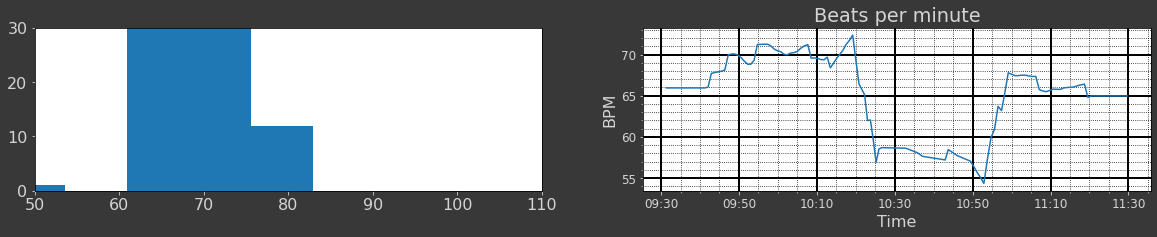

Number of R-peaks: 113
Averedge BPM: 66.12522596652472


100%|██████████| 92/92 [00:00<00:00, 62197.93it/s]


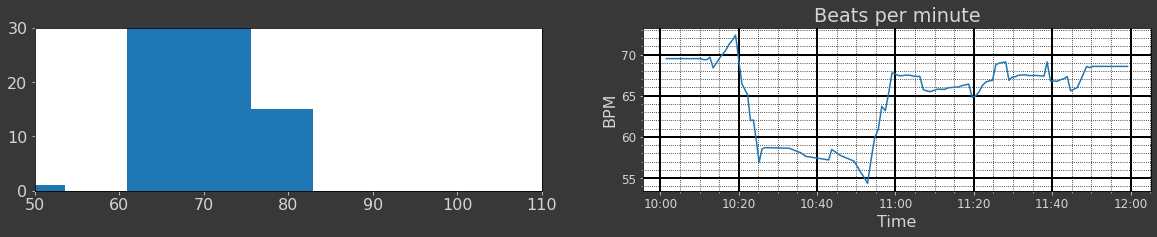

Number of R-peaks: 112
Averedge BPM: 65.69045124482763


100%|██████████| 91/91 [00:00<00:00, 76062.51it/s]


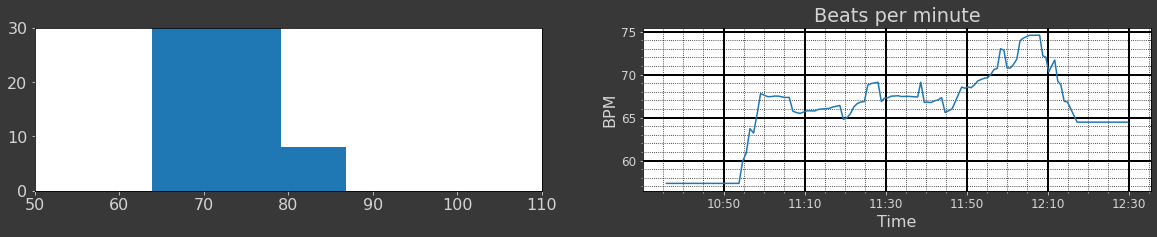

Number of R-peaks: 107
Averedge BPM: 66.54437578055607


100%|██████████| 86/86 [00:00<00:00, 103951.05it/s]


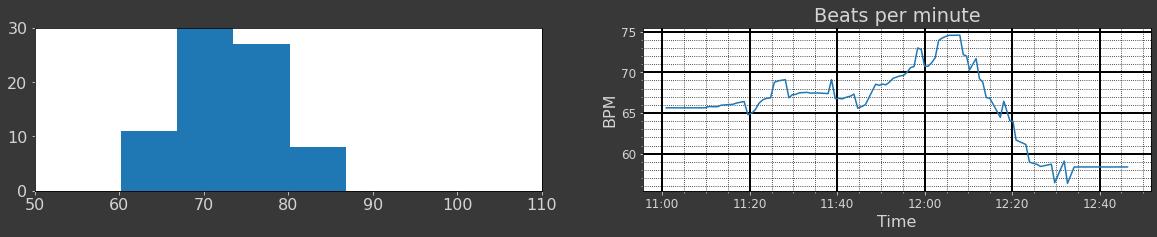

Number of R-peaks: 90
Averedge BPM: 62.91166908291084


100%|██████████| 69/69 [00:00<00:00, 68955.68it/s]


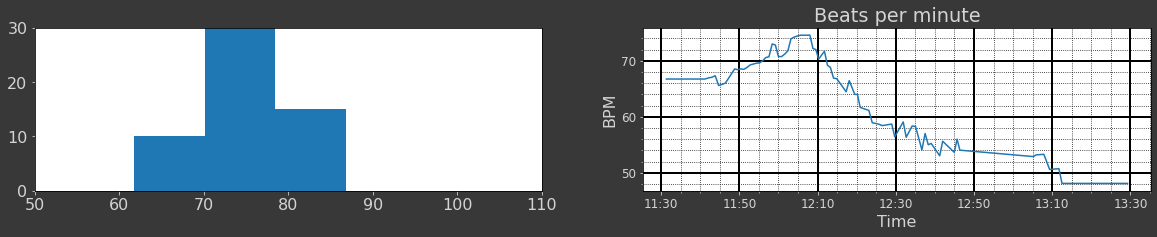

Number of R-peaks: 81
Averedge BPM: 59.0660248605072


100%|██████████| 60/60 [00:00<00:00, 28929.56it/s]


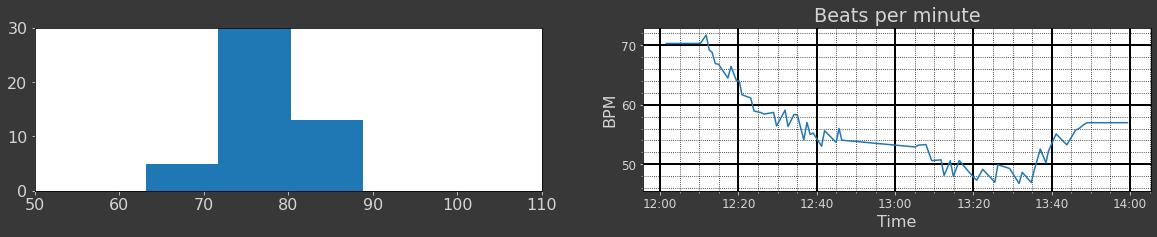

Number of R-peaks: 81
Averedge BPM: 60.30742899503677


100%|██████████| 60/60 [00:00<00:00, 154296.90it/s]


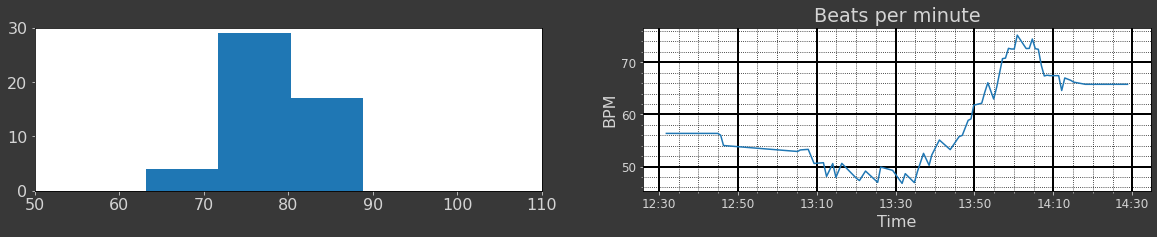

Number of R-peaks: 98
Averedge BPM: 62.8616823475126


100%|██████████| 77/77 [00:00<00:00, 175331.93it/s]


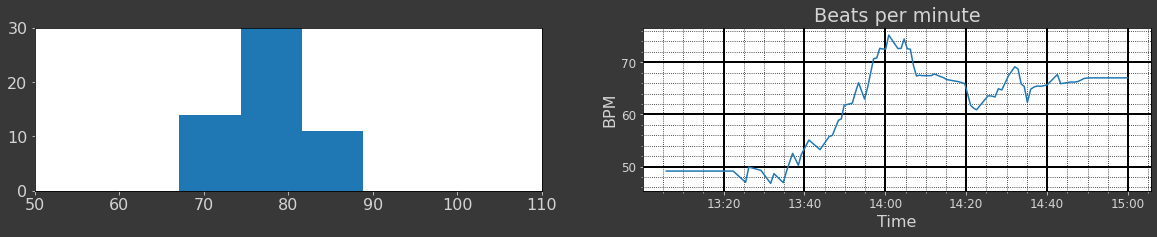

Number of R-peaks: 109
Averedge BPM: 64.47219669653376


100%|██████████| 88/88 [00:00<00:00, 80082.18it/s]


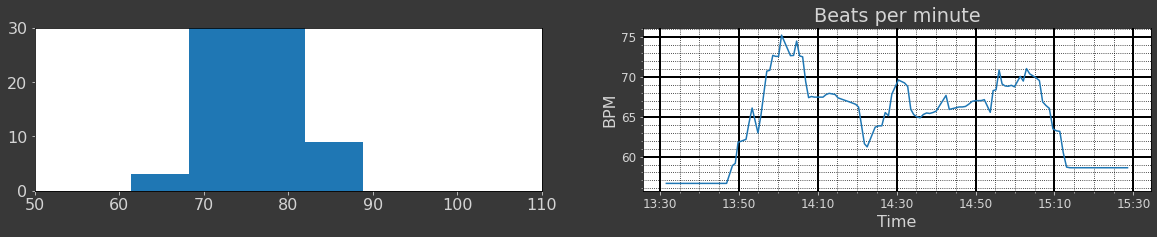

Number of R-peaks: 97
Averedge BPM: 62.77572698634528


100%|██████████| 76/76 [00:00<00:00, 119299.07it/s]


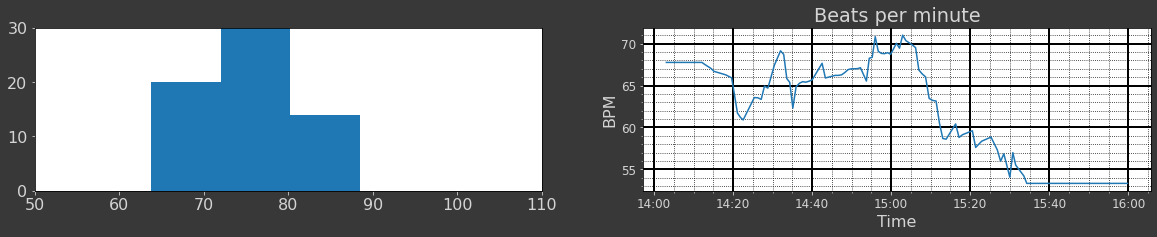

Number of R-peaks: 89
Averedge BPM: 60.40083503782532


100%|██████████| 68/68 [00:00<00:00, 73168.98it/s]


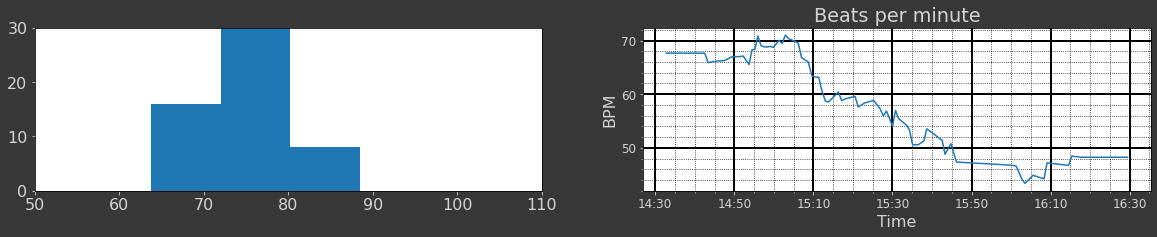

Number of R-peaks: 87
Averedge BPM: 59.847704653229385


100%|██████████| 66/66 [00:00<00:00, 147090.36it/s]


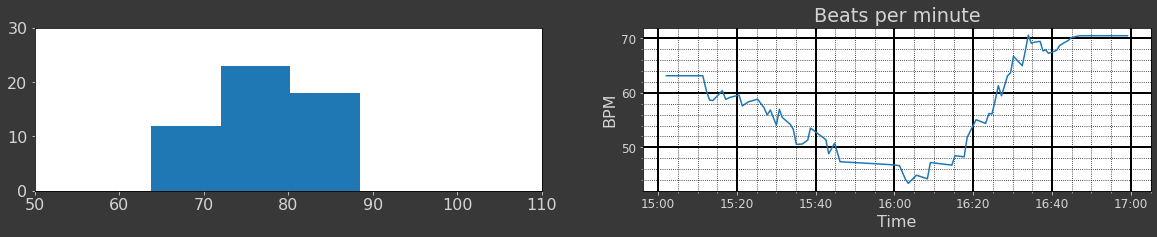

Number of R-peaks: 80
Averedge BPM: 57.41585732919211


100%|██████████| 59/59 [00:00<00:00, 55949.34it/s]


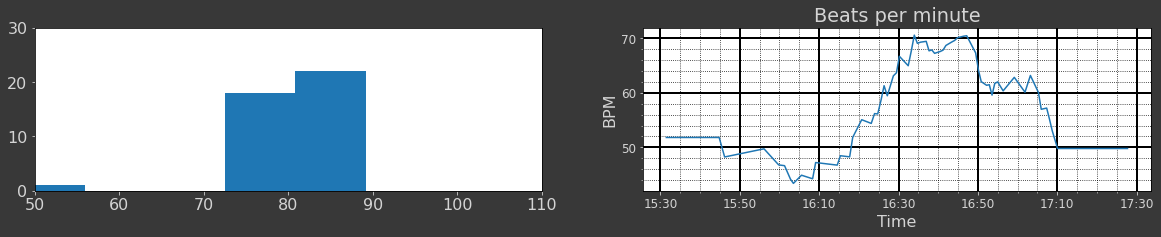

Number of R-peaks: 75
Averedge BPM: 56.98989765081613


100%|██████████| 54/54 [00:00<00:00, 134897.21it/s]


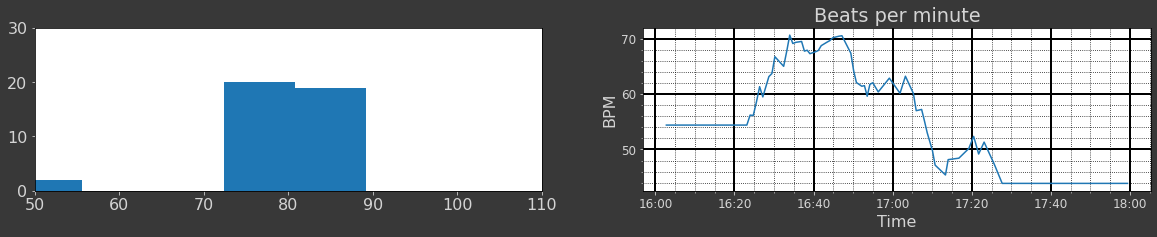

Number of R-peaks: 80
Averedge BPM: 59.2992196016329


100%|██████████| 59/59 [00:00<00:00, 104591.69it/s]


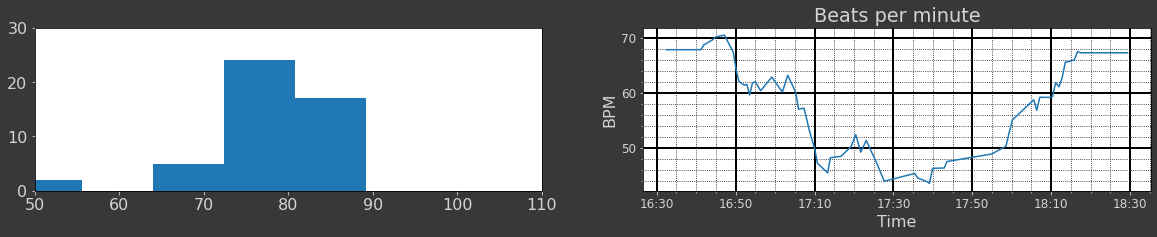

Number of R-peaks: 83
Averedge BPM: 60.09426702782052


100%|██████████| 62/62 [00:00<00:00, 134460.62it/s]


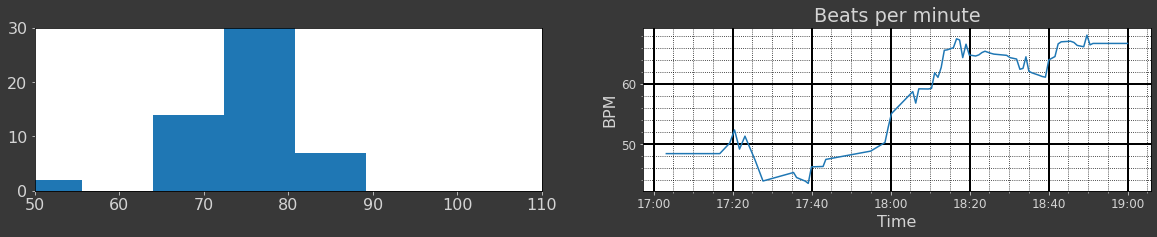

Number of R-peaks: 91
Averedge BPM: 64.57266085588441


100%|██████████| 70/70 [00:00<00:00, 124249.38it/s]


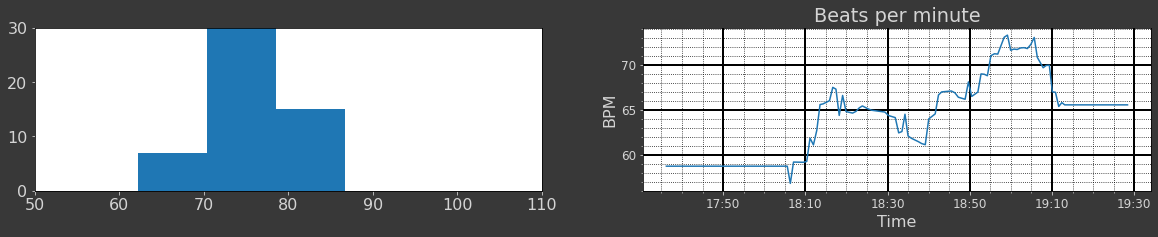

Number of R-peaks: 106
Averedge BPM: 65.05470232883721


100%|██████████| 85/85 [00:00<00:00, 128196.99it/s]


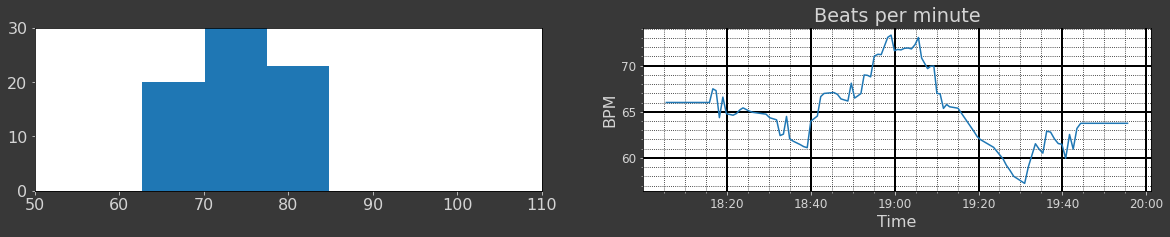

Number of R-peaks: 90
Averedge BPM: 62.51364388099295


100%|██████████| 69/69 [00:00<00:00, 131728.25it/s]


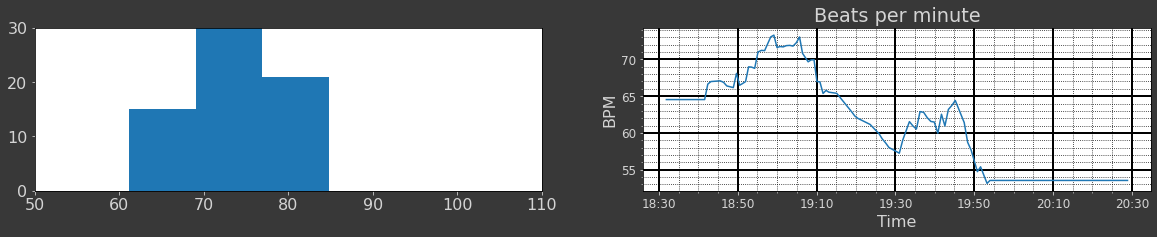

Number of R-peaks: 79
Averedge BPM: 58.28789001998266


100%|██████████| 58/58 [00:00<00:00, 54790.46it/s]


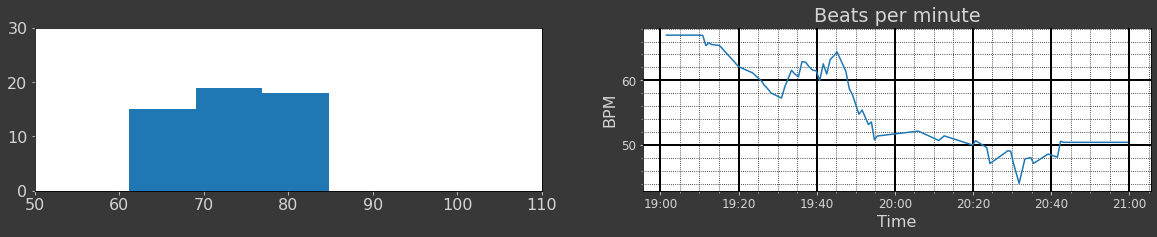

Number of R-peaks: 82
Averedge BPM: 59.0647507002082


100%|██████████| 61/61 [00:00<00:00, 61340.82it/s]


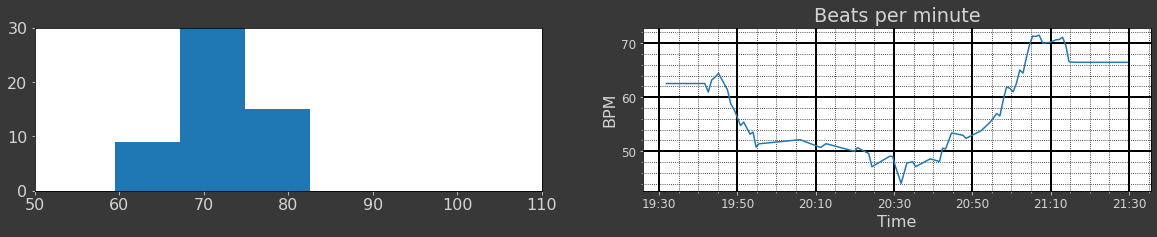

Number of R-peaks: 90
Averedge BPM: 62.561178708560874


100%|██████████| 69/69 [00:00<00:00, 146981.70it/s]


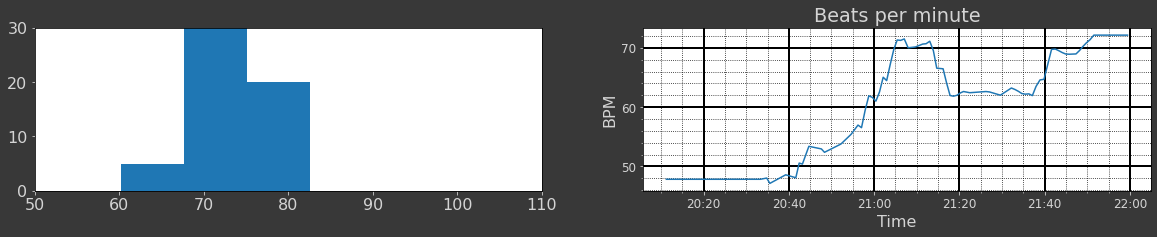

Number of R-peaks: 99
Averedge BPM: 62.962622258576296


100%|██████████| 78/78 [00:00<00:00, 113991.54it/s]


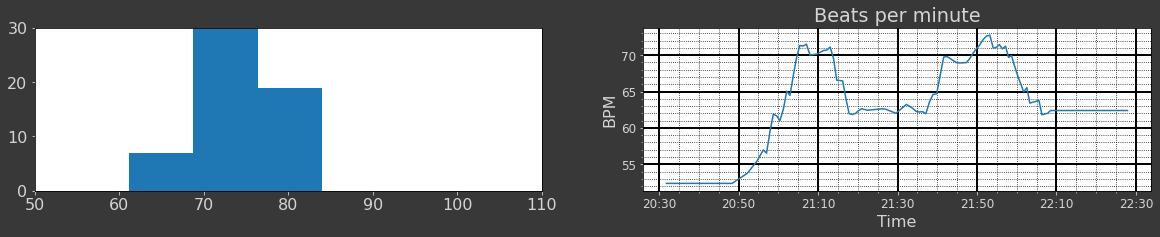

Number of R-peaks: 109
Averedge BPM: 65.964701677166


100%|██████████| 88/88 [00:00<00:00, 76544.74it/s]


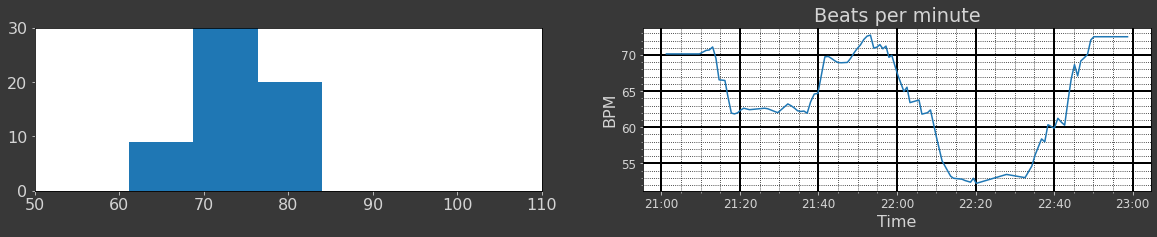

Number of R-peaks: 113
Averedge BPM: 67.71188411507954


100%|██████████| 92/92 [00:00<00:00, 75073.15it/s]


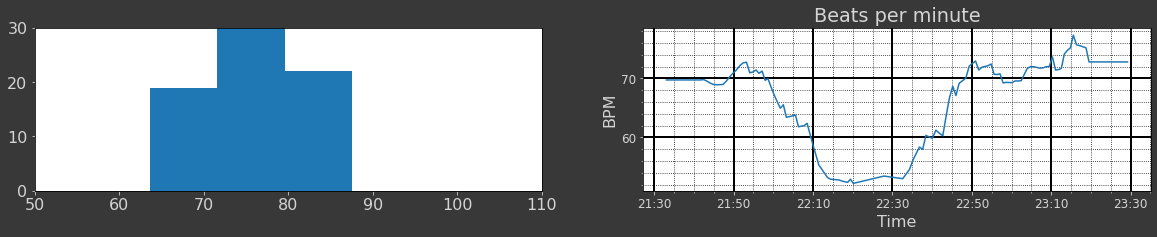

Number of R-peaks: 111
Averedge BPM: 67.64952425629123


100%|██████████| 90/90 [00:00<00:00, 72163.52it/s]


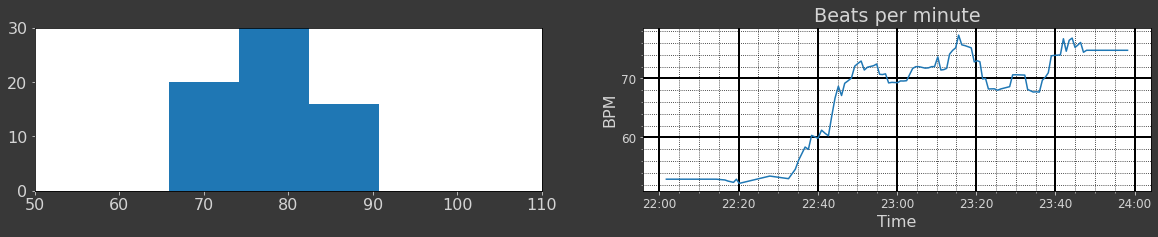

Number of R-peaks: 99
Averedge BPM: 68.93983535480774


100%|██████████| 78/78 [00:00<00:00, 72976.96it/s]


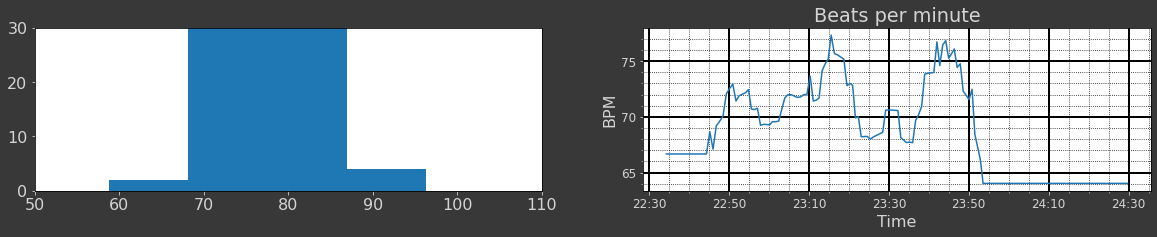

Number of R-peaks: 106
Averedge BPM: 70.5095492709481


100%|██████████| 85/85 [00:00<00:00, 77672.30it/s]


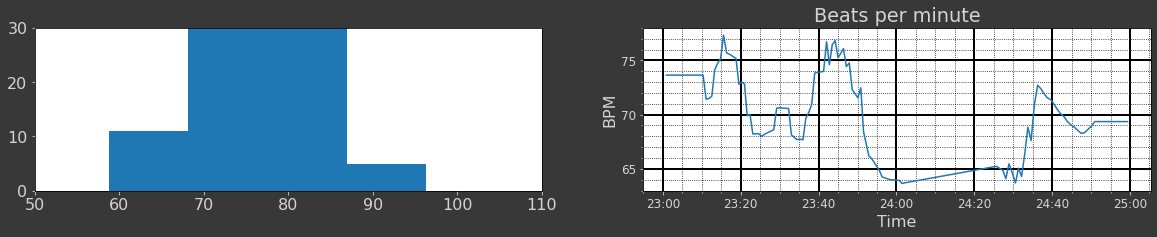

Number of R-peaks: 106
Averedge BPM: 71.6159632447035


100%|██████████| 85/85 [00:00<00:00, 139372.89it/s]


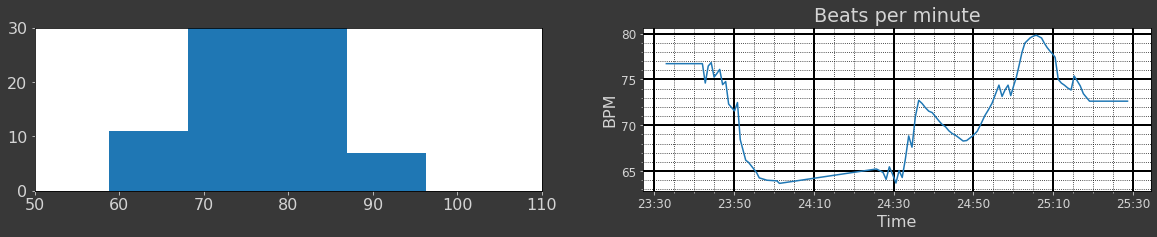

Number of R-peaks: 105
Averedge BPM: 70.55671602678333


100%|██████████| 84/84 [00:00<00:00, 147847.90it/s]


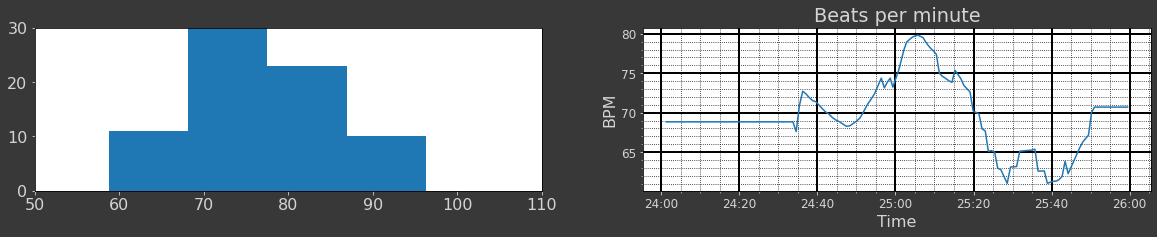

Number of R-peaks: 111
Averedge BPM: 68.80406840229485


100%|██████████| 90/90 [00:00<00:00, 125997.12it/s]


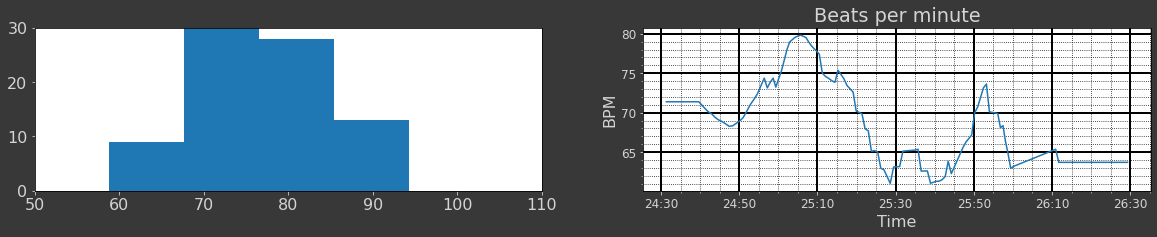

Number of R-peaks: 97
Averedge BPM: 66.94490420356821


100%|██████████| 76/76 [00:00<00:00, 74062.99it/s]


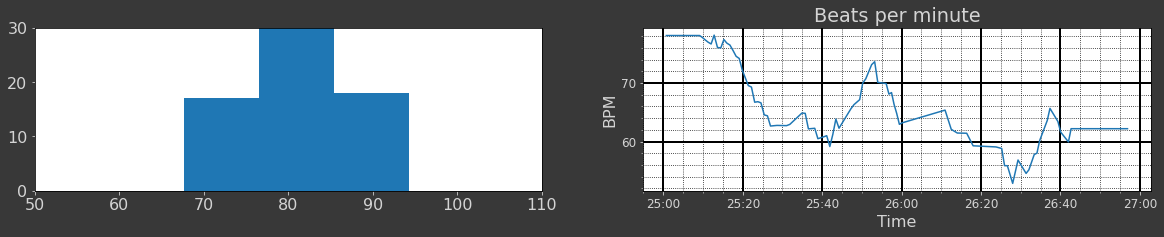

Number of R-peaks: 64
Averedge BPM: 61.551932849293124


100%|██████████| 43/43 [00:00<00:00, 108321.36it/s]


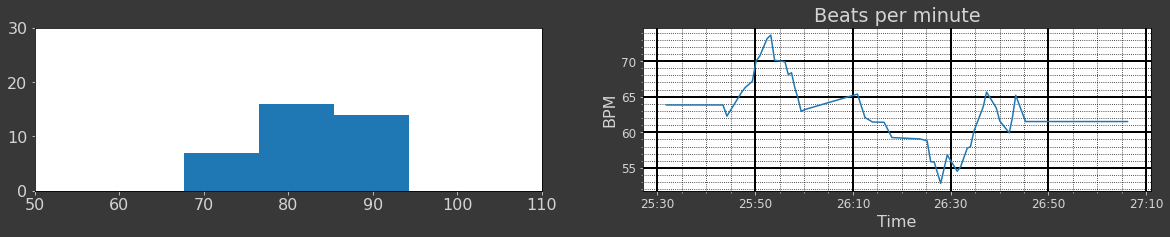

Number of R-peaks: 36
Averedge BPM: 55.16021135552051


100%|██████████| 15/15 [00:00<00:00, 56274.20it/s]


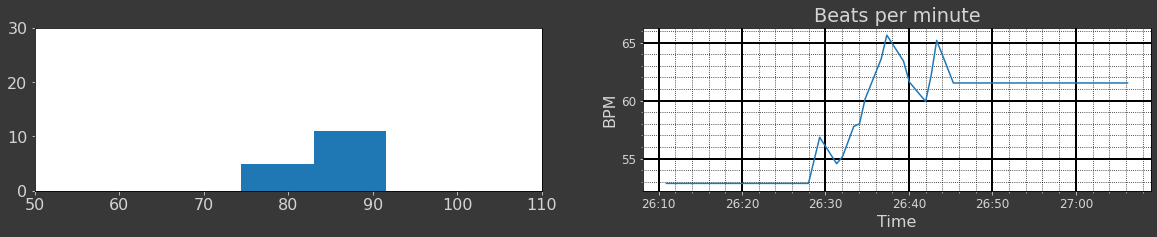

Number of R-peaks: 23
Averedge BPM: 60.465156799322195


100%|██████████| 2/2 [00:00<00:00, 10330.80it/s]


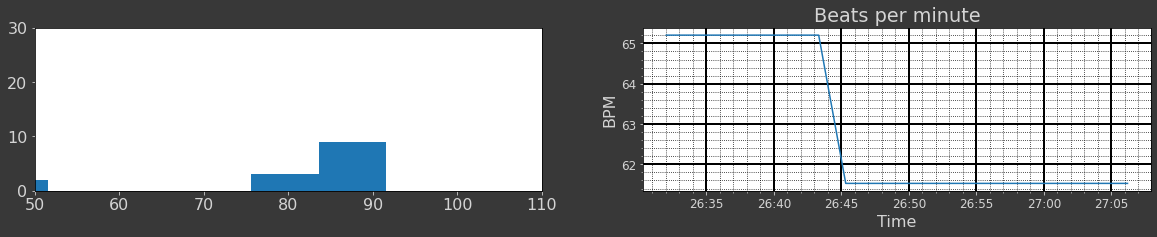

In [31]:
p, H = 'Gena', 20
for i in range(36):
  BPM_vis(p, f'9:{30*i}', f'11:{30*i}', h=H)


In [ ]:
rythms('Airat')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(36):
  BPM_vis('Gena', f'6:{46+i*30}', f'8:{46+i*30}')

Output hidden; open in https://colab.research.google.com to view.

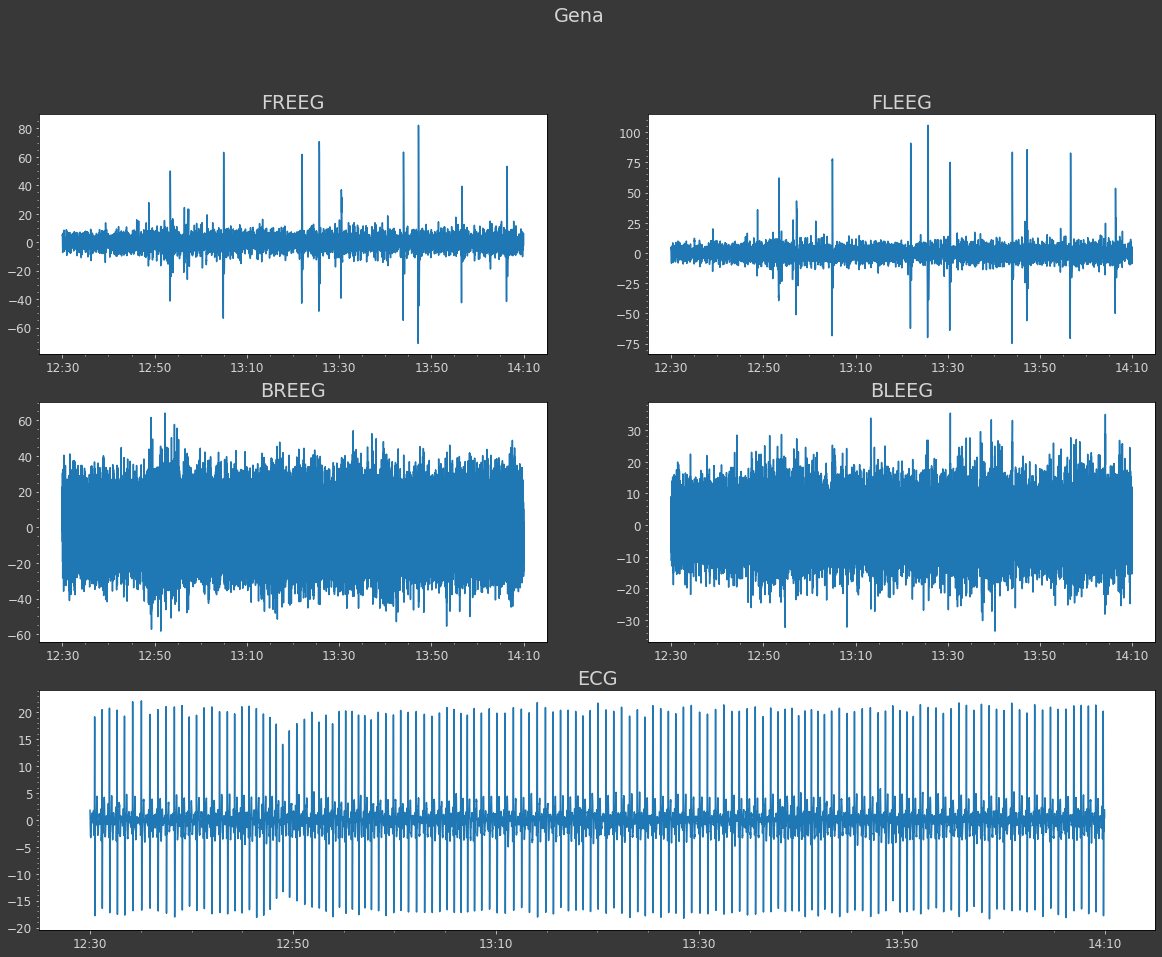

In [ ]:
visualize('Gena', '12:30', '14:10')

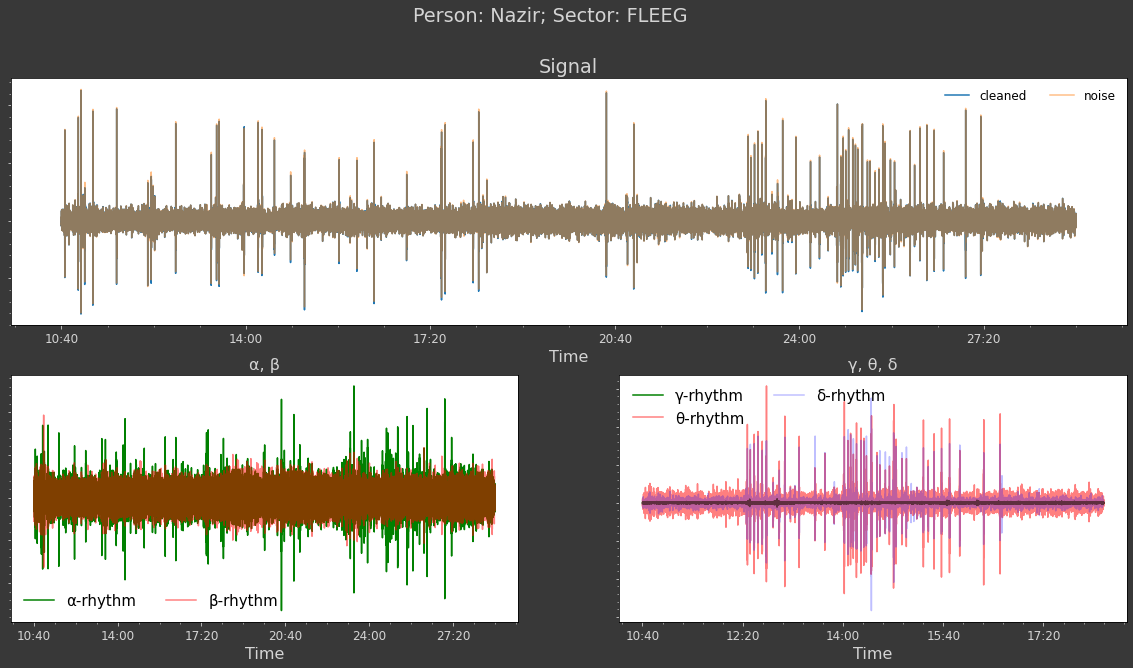

In [ ]:
rythms('Nazir', '10:40', '29:00', 'FLEEG')

Number of R-peaks: 1283
Averedge BPM: 53.93012896389512


100%|██████████| 1232/1232 [00:00<00:00, 137977.16it/s]


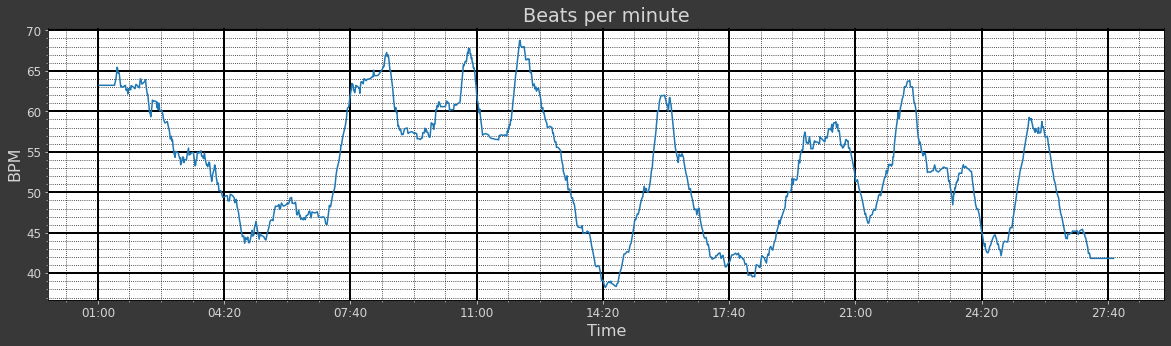

In [ ]:
BPM_vis('Gena')

Number of R-peaks: 1314
Averedge BPM: 44.92426716832436


100%|██████████| 1263/1263 [00:00<00:00, 148257.98it/s]


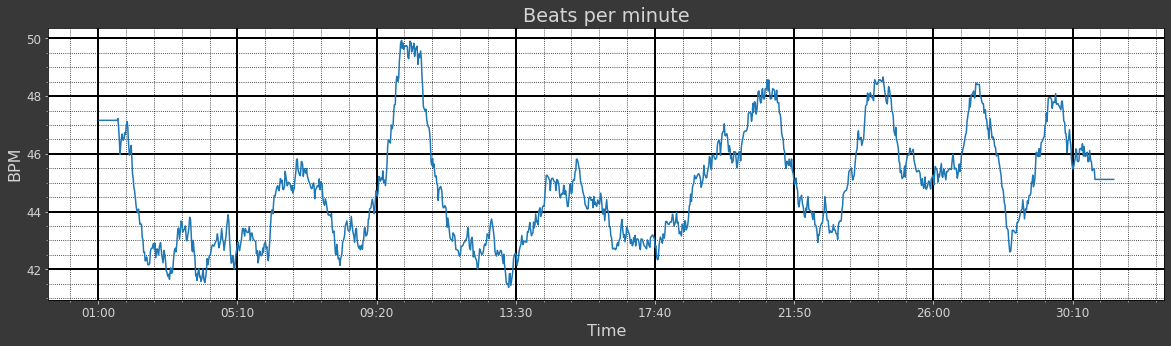

In [ ]:
BPM_vis('Nazir')

#betta

In [ ]:
def filt(person, ch='ECG', ma=60, mi=-60):
  res[person][ch] = list(map(lambda x: ma if x>ma else mi if x<mi else x, 
                             res[person][ch]))

In [ ]:
name = 'Nazir'
for i in sectors[:-1]:
  filt(name, i)
# filt(name, 'ECG', 10, -10)

In [ ]:
def readf(person):
  path = f'/content/drive/MyDrive/Study/Mag/1st/Neurophysiology/Lab3/{person}_tab.csv'
  return pd.read_csv(path, sep='\t')

In [ ]:
res0 = {i:readf(i) for i in persons}

In [ ]:
res0['Airat'].head()

,Elapsed Time,FREEG,FLEEG,BREEG,BLEEG,ECG,BioRadio Event,Unnamed: 7
0,00:00:00,"-1,2686425447464","-1,08672595024109","-1,24939227104187","-1,5323623418808","-0,0194391403347254",0,NaN
1,00:00:00.001,"-11,0024223327637","-9,42477893829346","-10,8356447219849","-13,28968334198","-0,16872850060463",0,NaN
2,00:00:00.002,"-47,9298286437988","-41,0573616027832","-47,2041358947754","-57,8944053649902","-0,735755562782288",0,NaN
3,00:00:00.003,"-143,224411010742","-122,688682556152","-141,058471679688","-173,002349853516","-2,20097017288208",0,NaN
4,00:00:00.004,"-336,669677734375","-288,398956298828","-331,583862304688","-406,670196533203","-5,17943239212036",0,NaN


In [ ]:
res1 = dict()
for person in persons:
  temp = dict()
  for sector in sectors + ['BioRadio Event']:
    temp[sector] = res0[person][sector].tolist()
  res1[person] = temp

In [ ]:
for person in persons:
  print(person)
  for sector in tqdm(sectors):
    res1[person][sector] = list(map(
        lambda x: x if type(x) == type(1.0) else float(x.replace(',', '.')), 
        res1[person][sector]
        ))

Airat


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Nazir


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Gena


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


In [ ]:
res1['Airat']['ECG'][:5]

[-0.0194391403347254,
 -0.16872850060463,
 -0.735755562782288,
 -2.20097017288208,
 -5.17943239212036]

In [ ]:
for i in persons:
  print(i)
  for j in sectors:
    res1[i][j] = _aprox(res[i][j])

Airat


100%|██████████| 2165344/2165344 [01:25<00:00, 25247.83it/s]


Nazir


100%|██████████| 1843992/1843992 [01:13<00:00, 25241.62it/s]


Gena


100%|██████████| 1629641/1629641 [01:04<00:00, 25280.56it/s]


In [ ]:
for person in persons:
  res1[person]['ECG'] = list(map(lambda x: 40 if x>40 else -40 if x<-40 else x, 
                                res1[person]['ECG']))

In [ ]:
res1['Nazir']['ECG'] = list(map(lambda x: 10 if x>10 else -10 if x<-10 else x, 
                               res1['Nazir']['ECG']))

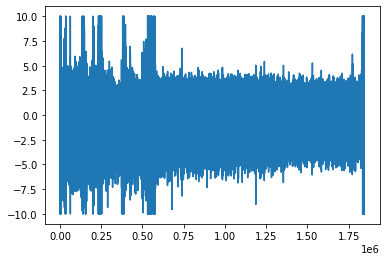

In [ ]:
plt.plot(res1['Nazir']['ECG'])

In [ ]:
with open('/content/drive/MyDrive/Study/Mag/1st/Neurophysiology/Lab3/resources.json', 'w') as f:
  json.dump(res1, f)

In [ ]:
def _aprox(y, d=200):
  y1 = list()
  y = np.array(y)
  for i in tqdm(range(len(y[d:]))):
    y1.append(sum(y[i:d+i])/d)
  y1 = [y1[0]]*(d//2) + y1 + [y1[-1]]*(d//2)
  return (y - y1).tolist()

In [ ]:
type(_aprox(res['Airat']['FREEG']))

100%|██████████| 2165344/2165344 [01:26<00:00, 25137.98it/s]


list